# FS20C8 -(Social) Media Analytics für Sportwetten
# Eugen Cuic



In [3]:
#import http.client
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import matplotlib.animation as animation
from sqlalchemy.sql import text
from pandas.io.json import json_normalize
from scipy.special import factorial
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


Bad key "text.kerning_factor" on line 4 in
C:\Users\M0268176\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Agenda

In order to create a full system from data to betting it is important to have a path to go. The work will contain following steps:

- Search data ressource
- Create connection to API
- Fetch the data
- Split the data into train and test sets
- Design Database
- Calculate statistical values
- Store data into an SQL Database
- Create a performance model for probability model
- Create interactive visualisation

# Search data ressource

## Match data
Consulting the website to figure out which leagues are included, one can check out following URL:

https://www.football-data.org/documentation/api

The two most interessting competitions are the German Bundesliga and the Englisch Premier League. Those two should contain most valuable data (as very popular in both countries).

In this work the focus will lie on the German Bundesliga

Code for the German Bundesliga ist: BL1

## Betting data
In order to being able to compare my own and the real betting statistics i will scrap history betting data from this website:

https://www.oddsportal.com/soccer/germany/bundesliga-2018-2019/results/


# Create connection to API
In the first instance, I will set up the connection to the API. This way I will make sure that I can call it later with less issues.

In [4]:
myUrl= 'http://api.football-data.org/v2/'
myToken = 'e10b4cdfa26a4d4eb2a01f1bb2122595'

head = {'X-Auth-Token': '{}'.format(myToken)}

# Fetch the data

In [6]:
# testing the connection to see what the output ist
response = requests.get(myUrl + "competitions/BL1/matches?season=2018", headers=head)

# showing the whole output would be too much for the notebook, if someone wants to see it just remove the # from the next line
response.json()

},
  {'id': 235975,
   'season': {'id': 155,
    'startDate': '2018-08-24',
    'endDate': '2019-05-18',
    'currentMatchday': 34},
   'utcDate': '2019-05-11T13:30:00Z',
   'status': 'FINISHED',
   'matchday': 33,
   'stage': 'REGULAR_SEASON',
   'group': 'Regular Season',
   'lastUpdated': '2019-05-11T19:20:30Z',
   'odds': {'msg': 'Activate Odds-Package in User-Panel to retrieve odds.'},
   'score': {'winner': 'HOME_TEAM',
    'duration': 'REGULAR',
    'fullTime': {'homeTeam': 3, 'awayTeam': 2},
    'halfTime': {'homeTeam': 1, 'awayTeam': 0},
    'extraTime': {'homeTeam': None, 'awayTeam': None},
    'penalties': {'homeTeam': None, 'awayTeam': None}},
   'homeTeam': {'id': 4, 'name': 'BV Borussia 09 Dortmund'},
   'awayTeam': {'id': 24, 'name': 'TSV Fortuna 95 Düsseldorf'},
   'referees': [{'id': 43943, 'name': 'Tobias Stieler', 'nationality': None},
    {'id': 56230, 'name': 'Matthias Jöllenbeck', 'nationality': None},
    {'id': 15747, 'name': 'Christian Gittelmann', 'nationality

As we can see above in the comented out line, the request is giving us all necessary data for the probability model:
- Matchday
- Team Names for Home Team
- Team Names for Away Team
- Goals for Home Team
- Goals for Away Team

And if we want to have another season we just adapt the request for the REST API
### !!WARNING!! (the free version of the API does not give more data then the season from 2018/2019)

The responses from the API contain a lot more data than we need for out model. This is the reason to figure out how we can extract all the necessary data and in a format that we could use later.
In the first step we will print out all matches, ordered by the matchday, and add the respective results to see what the way to go is, in order to extract the data

In [4]:
# iterrating through all JSON responses to extract the necessary data and also format it properly
for c in response.json()['matches']:
    print ("Matchday " + str(c['matchday']) + ": " + 
    c['homeTeam']['name'] + " - " + c['awayTeam']['name'] 
    + ": Result " + str(c['score']['fullTime']['homeTeam']) + " - " 
    + str(c['score']['fullTime']['awayTeam'] ) )

Matchday 1: FC Bayern München - TSG 1899 Hoffenheim: Result 3 - 1
Matchday 1: SV Werder Bremen - Hannover 96: Result 1 - 1
Matchday 1: Hertha BSC - 1. FC Nürnberg: Result 1 - 0
Matchday 1: TSV Fortuna 95 Düsseldorf - FC Augsburg: Result 1 - 2
Matchday 1: SC Freiburg - Eintracht Frankfurt: Result 0 - 2
Matchday 1: VfL Wolfsburg - FC Schalke 04: Result 2 - 1
Matchday 1: Borussia Mönchengladbach - Bayer 04 Leverkusen: Result 2 - 0
Matchday 1: 1. FSV Mainz 05 - VfB Stuttgart: Result 1 - 0
Matchday 1: BV Borussia 09 Dortmund - RB Leipzig: Result 4 - 1
Matchday 2: Hannover 96 - BV Borussia 09 Dortmund: Result 0 - 0
Matchday 2: Eintracht Frankfurt - SV Werder Bremen: Result 1 - 2
Matchday 2: 1. FC Nürnberg - 1. FSV Mainz 05: Result 1 - 1
Matchday 2: Bayer 04 Leverkusen - VfL Wolfsburg: Result 1 - 3
Matchday 2: TSG 1899 Hoffenheim - SC Freiburg: Result 3 - 1
Matchday 2: FC Augsburg - Borussia Mönchengladbach: Result 1 - 1
Matchday 2: VfB Stuttgart - FC Bayern München: Result 0 - 3
Matchday 2: 

As seen above it is neccessary to transform the integers into strings before being able to put them into one line with the other extracted data fragments.
Extracting those values separatelly is not an issue, but it is not possible to concatenate strings and integers together.

Before splitting the data, it will be put into a Pandas DataFrame to make it easier to work with, especially because the data is still in JSON Format which makes it hard to work with when it comes to statistical models

In [7]:
# normalizing JSON and create a Pandas DataFrame
raw_data = response.json()
data = json_normalize(raw_data['matches'])
data.head()

,id,utcDate,status,matchday,stage,group,lastUpdated,referees,season.id,season.startDate,...,score.halfTime.homeTeam,score.halfTime.awayTeam,score.extraTime.homeTeam,score.extraTime.awayTeam,score.penalties.homeTeam,score.penalties.awayTeam,homeTeam.id,homeTeam.name,awayTeam.id,awayTeam.name
0,235686,2018-08-24T18:30:00Z,FINISHED,1,REGULAR_SEASON,Regular Season,2019-03-16T17:30:32Z,"[{'id': 15746, 'name': 'Bastian Dankert', 'nat...",155,2018-08-24,...,1,0,None,None,None,None,5,FC Bayern München,2,TSG 1899 Hoffenheim
1,235688,2018-08-25T13:30:00Z,FINISHED,1,REGULAR_SEASON,Regular Season,2019-03-16T17:30:32Z,"[{'id': 43875, 'name': 'Felix Brych', 'nationa...",155,2018-08-24,...,0,0,None,None,None,None,12,SV Werder Bremen,8,Hannover 96
2,235689,2018-08-25T13:30:00Z,FINISHED,1,REGULAR_SEASON,Regular Season,2019-03-16T17:30:32Z,"[{'id': 57539, 'name': 'Tobias Welz', 'nationa...",155,2018-08-24,...,1,0,None,None,None,None,9,Hertha BSC,14,1. FC Nürnberg
3,235691,2018-08-25T13:30:00Z,FINISHED,1,REGULAR_SEASON,Regular Season,2019-03-16T17:30:32Z,"[{'id': 174, 'name': 'Markus Schmidt', 'nation...",155,2018-08-24,...,1,0,None,None,None,None,24,TSV Fortuna 95 Düsseldorf,16,FC Augsburg
4,235692,2018-08-25T13:30:00Z,FINISHED,1,REGULAR_SEASON,Regular Season,2019-03-16T17:30:32Z,"[{'id': 57510, 'name': 'Manuel Gräfe', 'nation...",155,2018-08-24,...,0,1,None,None,None,None,17,SC Freiburg,19,Eintracht Frankfurt


It was possible to put the data into the DataFrame and format it correctly, so far an possible optimization would be to see if it would be possible to put the data into the DataFrame directly after the extration some steps earlier.

As the DataFrame is becoming very big and it is not easy to see what the different column names are in the frame. It woudld also make sense to list all names to filter wich ones are necessary. 

In [8]:
# checking the different columns that are available
for col in data.columns: 
    print(col) 

id
utcDate
status
matchday
stage
group
lastUpdated
referees
season.id
season.startDate
season.endDate
season.currentMatchday
odds.msg
score.winner
score.duration
score.fullTime.homeTeam
score.fullTime.awayTeam
score.halfTime.homeTeam
score.halfTime.awayTeam
score.extraTime.homeTeam
score.extraTime.awayTeam
score.penalties.homeTeam
score.penalties.awayTeam
homeTeam.id
homeTeam.name
awayTeam.id
awayTeam.name


This overview of the column names makes it a lot easier to define which ones would make sense to add for the probability model. Bellow the columns that I will keep:

- ID: For further information, statistics etc. about a specific match it is necessary to now the ID
- Matchday: It would make sense to keep the matchday to have a dataset to order the data by
- score.fullTime.homeTeam: The result after fullTime is the most important number for the probability model
- score.fullTime.awayTeam: The result after fullTime is the most important number for the probability model
- homeTeam.id: The id is a shortcut to faster iterrate, find, select the teams across a season
- awayTeam.id: The id is a shortcut to faster iterrate, find, select the teams across a season
- homeTeam.name: The name is necessary to match id
- awayTeam.name: The name is necessary to match id  

In [9]:
# Define the header of the DataFrame 
header = ['id', 'matchday', 'score.fullTime.homeTeam', 'score.fullTime.awayTeam', 'homeTeam.id', 'awayTeam.id', 'homeTeam.name', 'awayTeam.name']
data_BL1_18_19 = pd.DataFrame(data, columns=header)

# Rename the columns to make it more understandable fo readers
data_BL1_18_19 = data_BL1_18_19.rename(columns={
    'id': 'match_id',
    'matchday': 'match_day',
    'score.fullTime.homeTeam': 'goals_home',
    'score.fullTime.awayTeam': 'goals_away',
    'homeTeam.id': 'home_id',
    'awayTeam.id': 'away_id',
    'homeTeam.name': 'home_name',
    'awayTeam.name': 'away_name'
    })

# Split the data into train and test set

In [10]:
# create copy to work with
data_BL1_18_19_copy = data_BL1_18_19.copy()
data_BL1_18_19_copy.set_index('match_id')

# using only 10% of random games for the test split
train_set = data_BL1_18_19_copy.sample(frac=0.9, random_state=0)
test_set  = data_BL1_18_19_copy.drop(train_set.index)

In [11]:
# Setting match_id as index
test_set = test_set.set_index('match_id')
train_set = train_set.set_index('match_id')

In [12]:
train_set

,match_day,goals_home,goals_away,home_id,away_id,home_name,away_name
match_id,,,,,,,
235961,31,4,1,24,12,TSV Fortuna 95 Düsseldorf,SV Werder Bremen
235755,8,2,2,3,8,Bayer 04 Leverkusen,Hannover 96
235945,29,2,0,2,9,TSG 1899 Hoffenheim,Hertha BSC
235896,24,0,1,14,721,1. FC Nürnberg,RB Leipzig
235847,18,0,1,721,4,RB Leipzig,BV Borussia 09 Dortmund
...,...,...,...,...,...,...,...
235720,4,1,1,2,4,TSG 1899 Hoffenheim,BV Borussia 09 Dortmund
235721,4,2,3,16,12,FC Augsburg,SV Werder Bremen
235814,15,2,1,10,9,VfB Stuttgart,Hertha BSC


# Design Database
In order to calculate all possible scenarios, betting rates and models the SQL DB needs:

- A table with all matches and results from season 2018/2019 (without the test data)
- A table with statistical factors to calculate probabilitie
- A table with the test data to check betting forecast against

In [17]:
#Create URI for DataBase connection
database_username ='sport'
database_password = 'sport_fhnw_20'
database_ip = '45.32.156.57'
database_port = '3306'
database_name = 'sportwetten'

database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name))

In [18]:
con = database_connection.connect()

### The first table to create in the schema is the one for the raw data, that we have seen before. The match ID is the unique number of every match and will also be used as primary key for this table. 

The data that will be stores in this seciton is the train data to set the statistical values

In [13]:
query = text("""
CREATE TABLE `sportwetten`.`match_data` (
  `match_id` INT NOT NULL,
  `match_day` INT NOT NULL,
  `goals_home` INT NOT NULL,
  `goals_away` INT NOT NULL,
  `home_id` INT NOT NULL,
  `away_id` INT NOT NULL,
  `home_name` VARCHAR(45) NOT NULL,
  `away_name` VARCHAR(45) NOT NULL,
  PRIMARY KEY (`match_id`),
  UNIQUE INDEX `match_id_UNIQUE` (`match_id` ASC))
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8;
""")

In [14]:
#Execute Query to create Table in DataBase
con.execute(query)

NameError: name 'con' is not defined

### The 2nd table is used to store all statistical values for the probability functions. Every team with ID and name will be store and additionaly the statistical value "lambda" to create the Poission distributions. Furthermore I will add a column with the information if the statistics is for away or at home as the statistics will slightly be different.

In [15]:
query = text("""
CREATE TABLE `sportwetten`.`team_statistics` (
  `team_id` INT NOT NULL,
  `team_name` VARCHAR(45) NOT NULL,
  `lambda_home` FLOAT NULL,
  `lambda_away` FLOAT NULL,
  PRIMARY KEY (`team_id`))
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8;
""")

In [16]:
#Execute Query to create Table in DataBase
con.execute(query)

NameError: name 'con' is not defined

### The 3rd table will contain the test data. In this table the forecast will happen. It will look the same as the 1st table with the raw train data, just with additional columns to put in the betting quotes for the match (predicted and real)

In [ ]:
query = text("""
CREATE TABLE `sportwetten`.`betting_data` (
  `match_id` INT NOT NULL,
  `match_day` INT NOT NULL,
  `goals_home` INT NOT NULL,
  `goals_away` INT NOT NULL,
  `home_id` INT NOT NULL,
  `away_id` INT NOT NULL,
  `home_name` VARCHAR(45) NOT NULL,
  `away_name` VARCHAR(45) NOT NULL,
  `home_victory_pred` FLOAT NULL,
  `away_victory_pred` FLOAT NULL,
  `draw_pred` FLOAT NULL,
  `home_victory_real` FLOAT NULL,
  `away_victory_real` FLOAT NULL,
  `draw_real` FLOAT NULL,
  PRIMARY KEY (`match_id`))
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8;
""")

In [ ]:
#Execute Query to create Table in DataBase
con.execute(query)

In [ ]:
# Prefill data that is availabe
train_set.to_sql(con=con, name='match_data', if_exists='append')

test_set.to_sql(con=con, name='betting_data', if_exists='append')

In [ ]:
# Select only two columns of DF
data = data_BL1_18_19_copy[['home_id', 'home_name']]
data = data.rename(columns={
    'home_id': 'team_id',
    'home_name': 'team_name',
    })

# Drop duplicates
data = data.drop_duplicates()

# Set team_id as index (primary key)
data = data.set_index('team_id')

In [ ]:
data.to_sql(con=con, name='team_statistics', if_exists='append')

# Calculate statistical values

In the next step it is necessary to define what kind of probability distribution I should choose. There are two different kinds of random values of a distribution. A continuous and a discrete random variable. 

In the case of goals of a match, we have a discrete random variable and for such variables we are looking to find a distribution that gives every value a probability. In this case we are looking for a probability function. Possible probability functions are:

- Bernoulli distribution
- Binomial distribution
- Poisson distribution

As Bernoulli and Binomial distributions need probabilities for either success or fialure we need to drop those distributions as we don't have them. The Poisson distribution is regularly used when the attempts are high and the amounts of sucessful atempts low. In the case of football we have a lot ot atempts in a match (atempts to score a goal) but only a few succesfull ones (goals in a match).

In this section I will perform the calculation of lambda for every team based on the train set for home and away situations as those will be different (teams are differently motivated by the fans at home and away)

In [19]:
# Get the unique values of team ids
unique_team_ids = train_set['home_id'].unique()
print(unique_team_ids)

[ 24   3   2  14 721  15  12  11   6  10  19   5  17  16   8  18   9   4]


In [31]:
# Get all the home match data for a specific team
home_matches = train_set.loc[(train_set['home_id'] == 17)]
home_matches

,match_day,goals_home,goals_away,home_id,away_id,home_name,away_name
match_id,,,,,,,
235847,18,0,1,721,4,RB Leipzig,BV Borussia 09 Dortmund
235820,15,4,1,721,15,RB Leipzig,1. FSV Mainz 05
235784,11,3,0,721,3,RB Leipzig,Bayer 04 Leverkusen
235928,27,5,0,721,9,RB Leipzig,Hertha BSC
235730,5,2,0,721,10,RB Leipzig,VfB Stuttgart
235964,31,2,1,721,17,RB Leipzig,SC Freiburg
235766,9,0,0,721,6,RB Leipzig,FC Schalke 04
235946,29,2,0,721,11,RB Leipzig,VfL Wolfsburg
235703,2,1,1,721,24,RB Leipzig,TSV Fortuna 95 Düsseldorf


In [32]:
# Get all the away match data for a specific team
away_matches = train_set.loc[(train_set['away_id'] == 17)]
away_matches

,match_day,goals_home,goals_away,home_id,away_id,home_name,away_name
match_id,,,,,,,
235896,24,0,1,14,721,1. FC Nürnberg,RB Leipzig
235934,28,2,4,3,721,Bayer 04 Leverkusen,RB Leipzig
235687,1,4,1,4,721,BV Borussia 09 Dortmund,RB Leipzig
235913,26,0,1,6,721,FC Schalke 04,RB Leipzig
235862,20,0,3,8,721,Hannover 96,RB Leipzig
235876,22,1,3,10,721,VfB Stuttgart,RB Leipzig
235738,6,1,2,2,721,TSG 1899 Hoffenheim,RB Leipzig
235984,34,2,1,12,721,SV Werder Bremen,RB Leipzig
235825,16,1,0,5,721,FC Bayern München,RB Leipzig


The only statistical value that is needed for a Poission distribution is lambda. In order to calculate lambda we will assume that the expected value of goals is lambda (based on the theorie of the Poission distribution)

In [33]:
# Calculate lambda for home matches
lambda_home = home_matches['goals_home'].sum() / len(home_matches['goals_home'])
print(lambda_home)

2.125


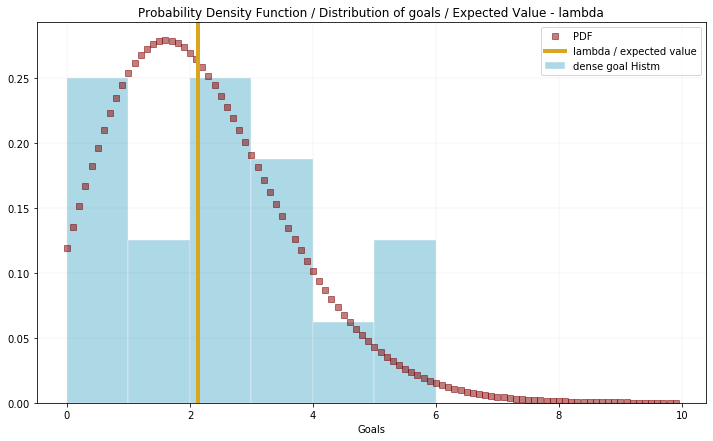

In [34]:
# Plot histogramm of goals per match, expected value of goals and poission density function

plt.figure(figsize=(12,7)) 

# Plot histogram of goals
plt.hist(home_matches['goals_home'], 
         bins=6, density=True, 
         histtype='bar', color='lightblue',
         edgecolor='white', linewidth=0.4,
         label='dense goal Histm')

# Create Poission distriution for calculated lambda value
t = np.arange(0, 10, 0.1)
d = np.exp(-lambda_home)*np.power(lambda_home, t)/factorial(t)
plt.plot(t, d, 'bs', color='maroon', alpha=0.5, label='PDF')

# Plot lambda value as vertical line
plt.axvline(x=lambda_home, color='goldenrod', lw=4, label='lambda / expected value')

# Visuals
plt.title("Probability Density Function / Distribution of goals / Expected Value - lambda")
#plt.ylabel("Number of Games")
plt.xlabel("Goals") 
plt.legend(loc='upper right')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.3)

plt.show()

Due to the lack of available data (Corona Virus) the error rate of the function might be too high. Still, I will continue with this approach. As I follow the rule to not repeat myself I will construc a function to extract the lambda values for each team in an easy manner

In [23]:
def calculate_lambda(team_id):
    # Get all the home match data for a specific team
    home_matches = train_set.loc[(train_set['home_id'] == team_id)]

    # Get all the away match data for a specific team
    away_matches = train_set.loc[(train_set['away_id'] == team_id)]

    lambda_home = home_matches['goals_home'].sum() / len(home_matches['goals_home'])

    lambda_away = away_matches['goals_away'].sum() / len(away_matches['goals_away'])
    
    lambda_h = ("UPDATE `team_statistics` SET `lambda_home` = {} WHERE `team_id` = {};").format(lambda_home, team_id)
    lambda_a = ("UPDATE `team_statistics` SET `lambda_away` = {} WHERE `team_id` = {};").format(lambda_away, team_id)

    con.execute(lambda_h)
    con.execute(lambda_a)

In [24]:
# Calculating for all teams the lambda for home and away and store it in the table "team_statistics"
for team_id in unique_team_ids:
    calculate_lambda(team_id)

# Create a performance model for probability model
In order to calculate the outcome of a match between two teams I will let both teams play virtually a couple of tousand times to see how many times each team will winn or how many times we will see a draw. In order to do so I will proceed with following steps:
- Check which team is playing at home and away
- Load the respective lambdas for each team
- Perform a Monte Carlo Simulation several tousand times with a Poission distribution
- --> The Poission distribution will calculate how many goals each team will socre
- --> The goals are rounded to integers
- Evaulate the results:
- --> The team with more goals will win
- --> The team with less goals will lose
- --> If both teams have same amount of goals, it's a draw

Before creating the function, I will build it step by step with some pre defined examples

In [25]:
# Fetching lambda values for home and away team
team_id_home = 17
data = 'SELECT lambda_home FROM sportwetten.team_statistics WHERE team_id = %i' % team_id_home
data_df = pd.read_sql(data, con=con)
lambda_home_team = data_df['lambda_home'][0]
print(lambda_home_team)

team_id_away = 5
data = 'SELECT lambda_away FROM sportwetten.team_statistics WHERE team_id = %i' % team_id_away
data_df = pd.read_sql(data, con=con)
lambda_away_team = data_df['lambda_away'][0]
print(lambda_away_team)

1.85714
2.4375


In [26]:
# Check what would be the output based on a random poission distribution
goals_home = round(np.random.poisson(lambda_home_team))
print(goals_home)

goals_away = round(np.random.poisson(lambda_away_team))
print(goals_away)

4
0


In [27]:
# Setting the counting values at zero
win_home = 0
win_away = 0
draw = 0

In [28]:
# Implement logic to count end result of matches
if goals_home > goals_away:
    win_home += 1
elif goals_home < goals_away:
    win_away += 1
else:
    draw += 1

In [29]:
# Print the counting values to see if the result machtes with counting
print(win_away)
print(win_home)
print(draw)

0
1
0


In [24]:
def match_prediction_prob (team_away_id, team_home_id, iterrations):

    # Fetch lambda value for home and away team
    data = 'SELECT lambda_home FROM sportwetten.team_statistics WHERE team_id = %i' % team_home_id
    data_df = pd.read_sql(data, con=con)
    lambda_home_team = data_df['lambda_home'][0]

    data = 'SELECT lambda_away FROM sportwetten.team_statistics WHERE team_id = %i' % team_away_id
    data_df = pd.read_sql(data, con=con)
    lambda_away_team = data_df['lambda_away'][0]

    # Setting counting values at zero
    win_home = 0
    win_away = 0
    draw = 0
    attempts = 0

    # calculate the number of steps for interactive visualisation
    steps = 10
    lenght_df = int((iterrations/steps))

    # create an empty DataFrame to be filled for interactive visualisation
    feature_list = ['matches', 'wins_home', 'wins_away', 'draws']
    df_viz = pd.DataFrame(0, index=np.arange(lenght_df), columns=feature_list)


    for n in range(iterrations):
        goals_home = np.random.poisson(lambda_home_team)
        goals_away = np.random.poisson(lambda_away_team)

        if goals_home > goals_away:
            win_home += 1
        elif goals_home < goals_away:
            win_away += 1
        else:
            draw += 1
        i = n+1

        if i % 10 == 0:
            i_int = int(i)
            step_index = int(i/steps)
            df_viz.at[i/steps, 'matches'] = i_int
            df_viz.at[i/steps, 'wins_home'] = win_home / (n+1)
            df_viz.at[i/steps, 'wins_away'] = win_away / (n+1)
            df_viz.at[i/steps, 'draws'] = draw/ (n+1)
    df_viz.matches = df_viz.matches.astype(int)
    return df_viz


In [25]:
predictions = match_prediction_prob(5,17,5000)
predictions.head(10)

,matches,wins_home,wins_away,draws
0,0,0.000000,0.000000,0.000000
1,10,0.200000,0.800000,0.000000
2,20,0.300000,0.550000,0.150000
3,30,0.266667,0.533333,0.200000
4,40,0.275000,0.550000,0.175000
5,50,0.280000,0.500000,0.220000
6,60,0.283333,0.483333,0.233333
7,70,0.314286,0.485714,0.200000
8,80,0.337500,0.475000,0.187500
9,90,0.333333,0.488889,0.177778


# Create interactive visualisation

As there are not many possibilities fram library perspective, I had to lean heavily on the work of Ted Petrou. Following things have been done by myself:
- Adapting Data to fit into the production
- Adapt styling
- Adapt description within the visualisations

The link to the work of Ted can be found here:

https://medium.com/dunder-data/create-a-bar-chart-race-animation-in-python-with-matplotlib-477ed1590096

In [107]:
def interactive_prediction (home_id, away_id, attempts):
    # Load data with the help of the previously created function
    data = match_prediction_prob(home_id, away_id, attempts).set_index('matches')

    # Get the last index of the DataFrame
    last = data.index[-1]
    data = data.reset_index()

    # Create a step to make sure every possible lenght of data can match the function
    df2 = data.loc[0:last]
    df2 = df2.reset_index()

    # Prolong the Frame to create space for intrapolation
    df2.index = df2.index * 5
    last_index = df2.index[-1] + 1
    df_expanded = df2.reindex(range(last_index))

    # Fill up the new created cells with NaN
    df_expanded['matches'] = df_expanded['matches'].fillna(method='ffill')
    df_expanded = df_expanded.set_index('matches')

    # Drop the old index columns, as this would only make a messy visualisation
    df_expanded = df_expanded.drop(columns=['index'])

    # Intrapolate linearly from one step to the next
    df_expanded = df_expanded.interpolate()

    # Create a ranking to make sure the colors remain at the same values
    df_rank_expanded = df_expanded.rank(axis=1, method='first')
    df_rank_expanded = df_rank_expanded.interpolate()

    # Define styling for the visualisation of the axles
    def nice_axes(ax):
        ax.set_facecolor('.2')
        ax.tick_params(labelsize=7, length=0)
        ax.grid(True, axis='x', color='grey')
        ax.set_axisbelow(True)
        [spine.set_visible(False) for spine in ax.spines.values()]

    # For every loop of pictures that is created the graphic must be cleared
    def init():
        ax.clear()
        nice_axes(ax)

    # Loops through all rows of DataFrame to create a "video"
    def update(i):
        for bar in ax.containers:
            bar.remove()
        y = df_rank_expanded.iloc[i]

        width = df_expanded.iloc[i]
        labels = df_expanded.columns
        ax.barh(y=y, width=width, color=colors, tick_label=labels)
        date_str = df_expanded.index[i]
        ax.set_title('fraction of occurences after %i matches' % date_str, fontsize='smaller')
        
    fig = plt.Figure(figsize=(9, 2), dpi=144)
    colors = plt.cm.tab10(range(3))
    ax = fig.add_subplot()

    # Use the animation library to put all the picutres into a slideshow which can appear as vides
    anim2 = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(df_expanded), 
                        interval=200, repeat=False)
    
    # Safe the created video
    anim2.save('pred_2.mp4')

In [110]:
interactive_prediction(8,6,200)